# Bike Montreal data science (Daily user predicton)

**Diclaimer**: If anyone is reading this, please note that this project is my first data science project. It is my first time using Jupyter notebooks, pandas, SQL and many other things. I have also deliberately decided to not follow a similar project as an example because I feared I would simply copy the work and not learn as much in consequence.  This means that this project will **not** follow best practices in the industry or even correct usage of tools and libraries. My goal was to blindly jump into a project and learn as I go.

## Objective

[Bixi](https://bixi.com/en) is Montreal's public bike share program. It has been in service since 2014 and now has close to 800 stations with close to 10000 bikes in the network. In a previous project where I first learned Python and webscrapping, I scrapped Bixi's open data since 2014 and the historical daily weather of Montreal. In this project, I will attempt to predict the daily usage of Bixi bikes based on the different trends and weather condition.

## Sections (TODO)

In [1]:
import helpers
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta

BIXI_TABLE_ID = 'bixi-montreal.bixi.all-rides'
WEATHER_TABLE_ID = 'bixi-montreal.bixi.mtl-weather'



## Creating our dataframe

Let's query from **gbq** the first and last day of bixi and weather data and see if there is any weather data missing.

In [176]:
first_day_bixi = helpers.get_min_value(BIXI_TABLE_ID, 'start_date')
last_day_bixi = helpers.get_max_value(BIXI_TABLE_ID, 'start_date')
first_day_weather = helpers.get_min_value(WEATHER_TABLE_ID, 'DATE')
last_day_weather = helpers.get_max_value(WEATHER_TABLE_ID, 'DATE')

enough_min = first_day_weather <= first_day_bixi
enough_max = last_day_weather >= last_day_bixi

if enough_min != True and enough_max != True:
  print(f'Need weather data since {first_day_bixi} and until {last_day_bixi}')
elif enough_min != True:
  print(f'Need weather data since {first_day_bixi}')
elif enough_max != True:
  print(f'Need weather data until {last_day_bixi}')
else:
  print('You have all the weather data you needed!')

You have all the weather data you needed!


Create our main dataframe called main_df

In [177]:
# create empty dataframe
main_df = pd.DataFrame(columns=('DATE', 'DAILY_COUNT', 'MEAN_TEMP', 'TOTAL_RAIN', 'TOTAL_SNOW'))


In [178]:
first_day_bixi = helpers.get_min_value(BIXI_TABLE_ID, 'start_date')
last_day_bixi = helpers.get_max_value(BIXI_TABLE_ID, 'start_date')

start_date = datetime.date(first_day_bixi.year, first_day_bixi.month, first_day_bixi.day)
end_date = datetime.date(last_day_bixi.year, last_day_bixi.month, last_day_bixi.day)

daily_weather_df = helpers.get_weather_data(start_date, end_date)

In [179]:
# Loop through each day and concat date, daily bixi count, all weather variables to the main dataframe.
increment_date = start_date

while(end_date >= increment_date):
  temp_daily_weather_df = daily_weather_df.loc[pd.to_datetime(daily_weather_df['DATE']).dt.date == increment_date]
  daily_count = helpers.get_daily_count(increment_date)['f0_'][0] 
  temp_df =  pd.DataFrame(data = {
  'DATE': [increment_date], 
  'DAILY_COUNT': [daily_count], 
  'MEAN_TEMP': [temp_daily_weather_df['MEAN_TEMP'].iloc[0]],
  'TOTAL_RAIN': [temp_daily_weather_df['TOTAL_RAIN'].iloc[0]],
  'TOTAL_SNOW': [temp_daily_weather_df['TOTAL_SNOW'].iloc[0]],
  })

  main_df = pd.concat([main_df, temp_df])
  print(main_df.tail(1))
  increment_date += relativedelta(days=1)

print(main_df.shape)

So it took exactly 60 minutes to create the dataset. Let's create a csv file to prevent redoing this.

In [6]:
# Export the dataframe as csv

# REMOVE THIS AT THE END!!!
# main_df.to_csv('main-bixi-data.csv', index = False, header=True)

main_df = pd.read_csv('main-bixi-data.csv')

## Light data exploration 

In [55]:
# have an idea of how the data looks like
main_df.head(5)

,DATE,DAILY_COUNT,MEAN_TEMP,TOTAL_RAIN,TOTAL_SNOW
0,2014-04-15,1577,5.6,8.6,0.4
1,2014-04-16,3180,-3.4,0.0,0.0
2,2014-04-17,5852,2.4,0.0,0.0
3,2014-04-18,5325,6.3,0.0,0.0
4,2014-04-19,6031,5.1,0.4,0.0


In [8]:
# How many rows and columns?
main_df.shape

(2969, 5)

In [9]:
# What types are each of the columns?
main_df.dtypes

DATE            object
DAILY_COUNT      int64
MEAN_TEMP      float64
TOTAL_RAIN     float64
TOTAL_SNOW     float64
dtype: object

In [10]:
# How many NAN do I have per column?
main_df.isna().sum()

DATE            0
DAILY_COUNT     0
MEAN_TEMP      12
TOTAL_RAIN     25
TOTAL_SNOW     11
dtype: int64

**Findings** 
- There are 3058 days of data.
- I saved the daily count as an object instead of an int for some reason... 😅
- Both DATE and DAILY_COUNT columns have no missing data. 
- MEAN_TEMP has 12 NAN values, TOTAL_RAIN has 15 NAN values and TOTAL_SNOW has 11 NAN. (Considering we have 3058 days of data, it's not too bad).

## Data cleaning

Some amount of cleaning was done during the webscrapping. In retrospect, I am thinking that it would have been better practice to scrape the *dirty* data as is and clean it all at one place... This being said, here are the issues I need to fix:

- Clone the main_df and do all cleaning on this one. That way I won't loose the original dataframe.
- Convert the DAILY_COUNT column to an int
- Replace the NAN values int the different columns.

In [11]:
# Clone the main_df to keep it intact for the rest of the project
main_df_cleaned = main_df

In [12]:
# Convert DAILY_COUNT column to int.
main_df_cleaned = main_df_cleaned.astype({'DAILY_COUNT': 'int32'})


In [13]:
# fill NAN with previous values using the backfill method (Should be an ok solution since we are talking about a handful of data points in more than 3000 days of data) 
main_df_cleaned = main_df_cleaned.fillna(method = 'backfill')

In [14]:
main_df_cleaned.to_csv('cleaned-main-bixi-data.csv', index = False, header=True)

## Data exploration

- plot temp, rain, snow with Daily rides
- plot month with daily rides
- plot day of week (Monday to Sunday) vs rides
- plot year vs rides 

Let's remove all rows with 0 as DAILY_COUNT value. These are the days where Bixi is ot in service (Winter months in Canada). Keeping them in certain plots makes no sense...

In [102]:
# removing rows with DAILY_COUNT equal to 0.
main_df_cleaned_active = main_df_cleaned[main_df_cleaned['DAILY_COUNT'] != 0]
main_df_cleaned_active = main_df_cleaned_active.reset_index(drop=True)
main_df_cleaned_active

,DATE,DAILY_COUNT,MEAN_TEMP,TOTAL_RAIN,TOTAL_SNOW
0,2014-04-15,1577,5.6,8.6,0.4
1,2014-04-16,3180,-3.4,0.0,0.0
2,2014-04-17,5852,2.4,0.0,0.0
3,2014-04-18,5325,6.3,0.0,0.0
4,2014-04-19,6031,5.1,0.4,0.0
...,...,...,...,...,...
1762,2022-05-27,26532,19.1,31.2,0.0
1763,2022-05-28,47495,18.1,1.0,0.0
1764,2022-05-29,52075,19.4,0.0,0.0
1765,2022-05-30,43544,21.5,0.0,0.0


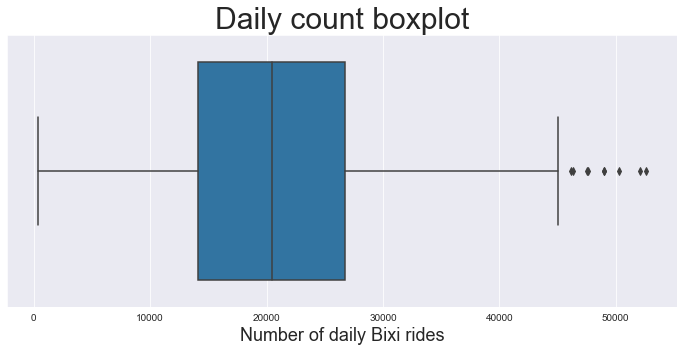

In [58]:
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = 12,5

count_boxplot = sns.boxplot(x=main_df_cleaned_active['DAILY_COUNT'])
count_boxplot.set_title('Daily count boxplot', fontsize= 30)
count_boxplot.set_xlabel('Number of daily Bixi rides', fontsize = 18)
plt.show()

The Daily Count boxplot is quite symetric other than a few outliers to the right. The 2nd and 3rd quartile are noticably smaller than the 1rst and 4rth. So we can say tht 50% of the days, there is between 14000 and 26000 daily rides.


In [59]:
main_df_cleaned_active['DAILY_COUNT'].describe()

count     1767.000000
mean     20724.680249
std       9016.793032
min        334.000000
25%      14086.000000
50%      20489.000000
75%      26707.000000
max      52630.000000
Name: DAILY_COUNT, dtype: float64

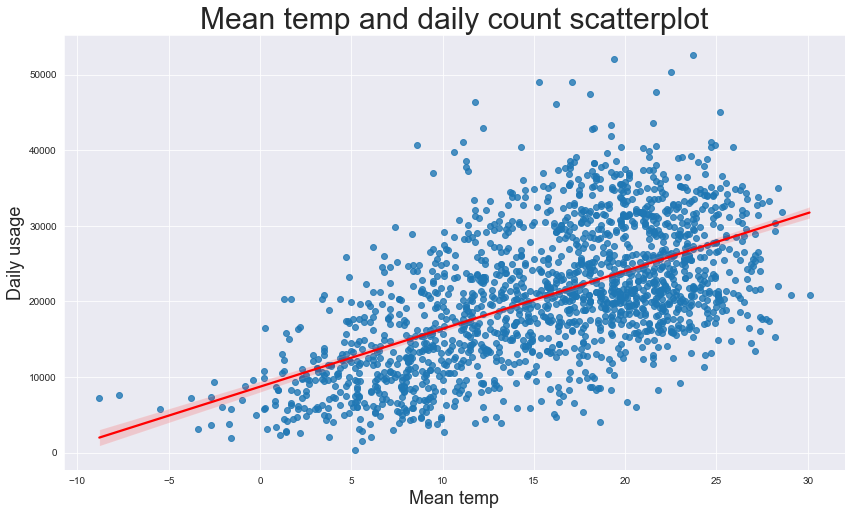

In [66]:
temp_scatter = sns.regplot(data=main_df_cleaned_active, x="MEAN_TEMP", y="DAILY_COUNT", line_kws={"color": "red"})
plt.rcParams['figure.figsize'] = 14,8
temp_scatter.set_title('Mean temp and daily count scatterplot', fontsize= 30)
temp_scatter.set_xlabel('Mean temp', fontsize = 18)
temp_scatter.set_ylabel('Daily usage', fontsize = 18)

plt.show()


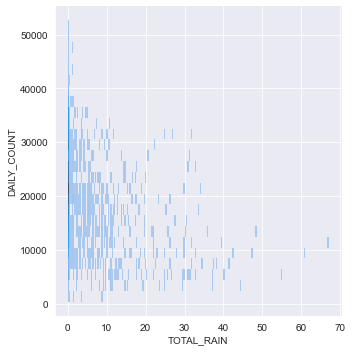

In [92]:
# rain_scatter = sns.regplot(data=main_df_cleaned_active, x="TOTAL_RAIN", y="DAILY_COUNT", line_kws={"color": "red"})
# plt.rcParams['figure.figsize'] = 14,8
# rain_scatter.set_title('Total rain and daily count scatterplot', fontsize= 30)
# rain_scatter.set_xlabel('Total rain', fontsize = 18)
# rain_scatter.set_ylabel('Daily usage', fontsize = 18)
# rain_scatter.set_xlim(0, 25)

rain_dist = sns.displot(data=main_df_cleaned_active, x = 'TOTAL_RAIN', y = 'DAILY_COUNT')
plt.show()

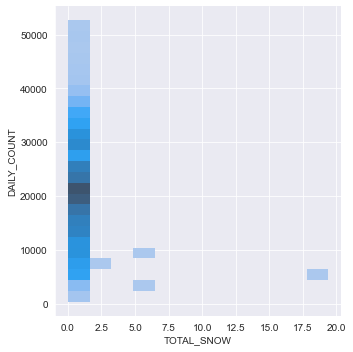

In [88]:
snow_dist = sns.displot(data=main_df_cleaned_active, x = 'TOTAL_SNOW', y = 'DAILY_COUNT')
plt.show()

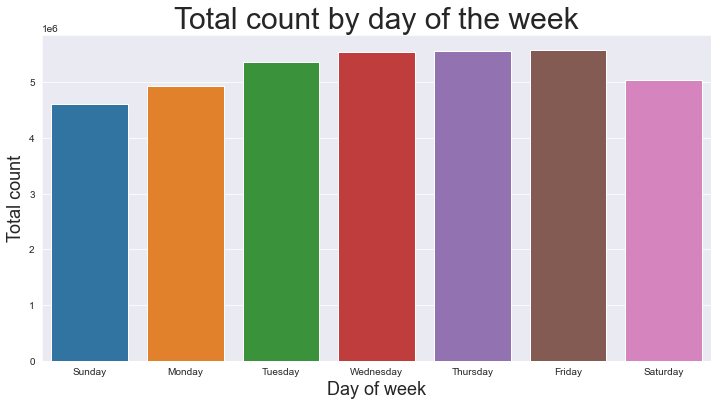

In [179]:
main_df_cleaned_active_day = main_df_cleaned_active.copy()
main_df_cleaned_active_day = main_df_cleaned_active_day.drop(columns=['MEAN_TEMP', 'TOTAL_RAIN', 'TOTAL_SNOW'])
main_df_cleaned_active_day.rename(columns = {'DATE':'DAY', 'DAILY_COUNT':'TOTAL_COUNT'}, inplace = True)
main_df_cleaned_active_day['DAY'] = pd.to_datetime(main_df_cleaned_active_day['DAY'])
main_df_cleaned_active_day['DAY'] = main_df_cleaned_active_day['DAY'].dt.day_name()
main_df_cleaned_active_day = main_df_cleaned_active_day.groupby(['DAY']).sum()

plt.rcParams['figure.figsize'] = 12,6
total_by_day = sns.barplot(x = main_df_cleaned_active_day.index, y = main_df_cleaned_active_day['TOTAL_COUNT'].values, order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
total_by_day.set_title('Total count by day of the week', fontsize= 30)
total_by_day.set_xlabel('Day of week', fontsize = 18)
total_by_day.set_ylabel('Total count', fontsize = 18)
plt.show()

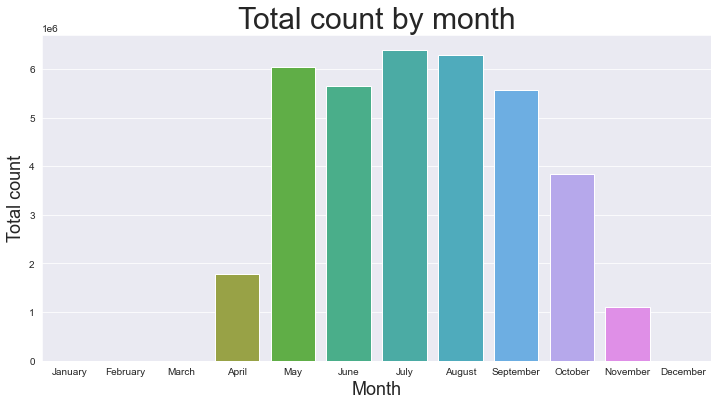

In [181]:
main_df_cleaned_month = main_df_cleaned.copy()
main_df_cleaned_month = main_df_cleaned_month.drop(columns=['MEAN_TEMP', 'TOTAL_RAIN', 'TOTAL_SNOW'])
main_df_cleaned_month.rename(columns = {'DATE':'MONTH', 'DAILY_COUNT':'TOTAL_COUNT'}, inplace = True)
main_df_cleaned_month['MONTH'] = pd.to_datetime(main_df_cleaned_month['MONTH'])
main_df_cleaned_month['MONTH'] = main_df_cleaned_month['MONTH'].dt.month_name()
main_df_cleaned_month = main_df_cleaned_month.groupby(['MONTH']).sum()
main_df_cleaned_month


plt.rcParams['figure.figsize'] = 12,6
total_by_month = sns.barplot(x = main_df_cleaned_month.index, y = main_df_cleaned_month['TOTAL_COUNT'].values, order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
total_by_month.set_title('Total count by month', fontsize= 30)
total_by_month.set_xlabel('Month', fontsize = 18)
total_by_month.set_ylabel('Total count', fontsize = 18)
plt.show()

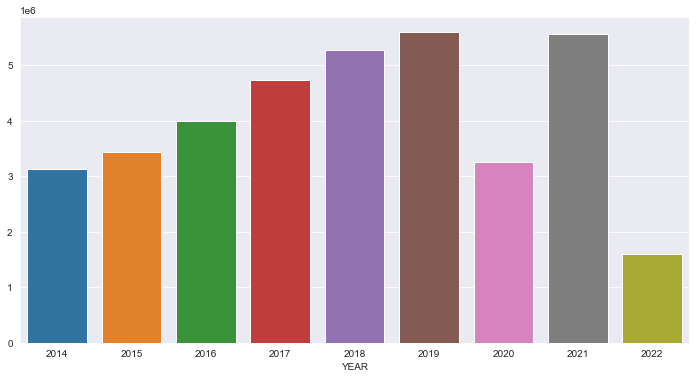

In [204]:
main_df_cleaned_year = main_df_cleaned.copy()
main_df_cleaned_year = main_df_cleaned_year.drop(columns=['MEAN_TEMP', 'TOTAL_RAIN', 'TOTAL_SNOW'])
main_df_cleaned_year.rename(columns = {'DATE':'YEAR', 'DAILY_COUNT':'TOTAL_COUNT'}, inplace = True)
main_df_cleaned_year['YEAR'] = pd.DatetimeIndex(main_df_cleaned_year['YEAR']).year
main_df_cleaned_year = main_df_cleaned_year.groupby(['YEAR']).sum()

plt.rcParams['figure.figsize'] = 12,6
total_by_year = sns.barplot(x = main_df_cleaned_year.index, y = main_df_cleaned_year['TOTAL_COUNT'].values, order=list(range(2014, 2023)))
total_by_month.set_title('Total count by year', fontsize= 30)
total_by_month.set_xlabel('Year', fontsize = 18)
total_by_month.set_ylabel('Total count', fontsize = 18)
plt.show()

### Observations

- The daily count boxplot is symetric. We can also see by looking at the quartile values that 50% of the daily count is between 14000 and 26000 rides.
- There seems to be some correlation between the mean temperature and the daily count but with very high variance.
- The the bulk of the rides are with days with 0 or very little total rain.
- Same observation with total snow.
- Sunday is the day of the week with the least amount of daily rides while Thurday, Friday and Saturday are neck to neck for the highest.
- The most popular month is July. April and November are the lowest. December, January, Febuary and March have 0 rides since the service is not offered for those months.
- It seems to gain in popularity year to year. It dropped massively in 2020 thanks to the mandatory confinement for Covid. 2021 Can back with force.
- We can't say anything for sure with 2022 since the year is only halfway done but it seems to be popular year also.   